In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']
# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG
import pydot

import pydrake.all
from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.common.containers import namedview
from underactuated import FindResource
from underactuated.jupyter import running_as_notebook


In [ ]:
ballbot_urdf = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".02" ixy="0" ixz="0" iyy="0.02" iyz="0" izz="0.02" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
        <box size="0.1 0.1 0.1"/>
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.018" ixy="0" ixz="0" iyy="0.018" iyz="0" izz="0.0288" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>

  <joint name="theta" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>

  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://82808fce57ec.ngrok.io/static/
Connected to meshcat-server.


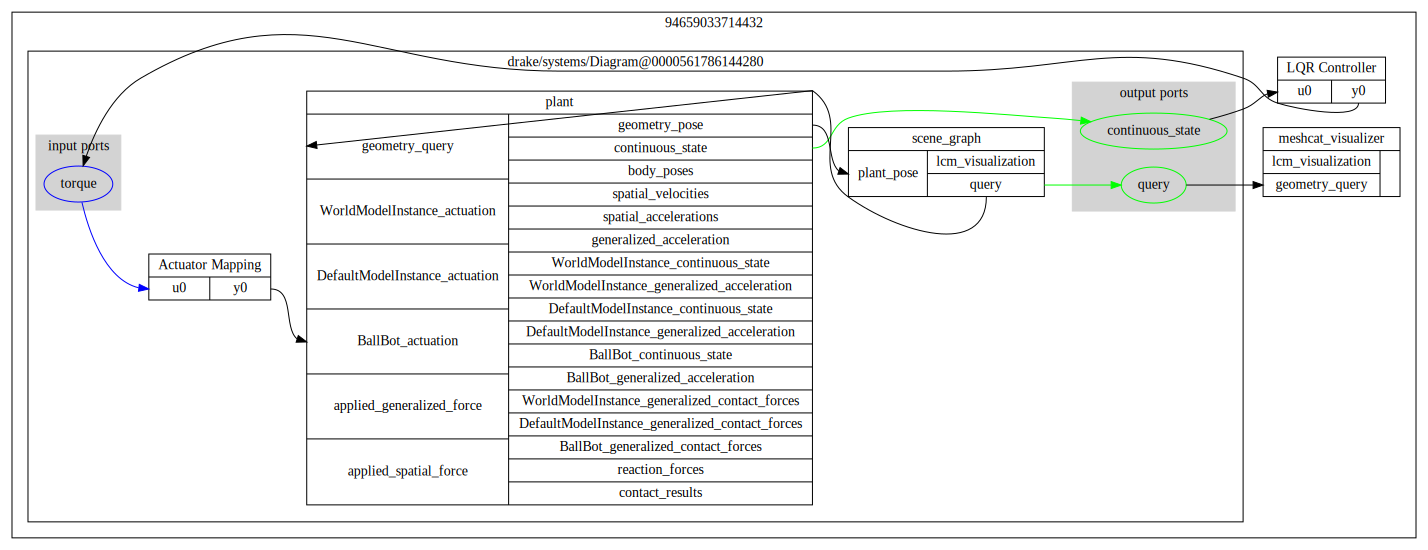

In [ ]:
def ballbot_example():
    def UprightState():
        state = (0, 0, 0, 0)
        return state


    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_input_port().FixValue(context, [0])

        context.get_mutable_continuous_state_vector().SetFromVector(UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = [1]

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R)


    def MakeBallBot():
        builder = DiagramBuilder()
        plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
        Parser(plant).AddModelFromString(ballbot_urdf, "urdf")
        plant.Finalize()
        # Applying a torque between the ball and the bot torques the bot, but also causes a 
        # force at the ground (the radius of the ball is entered as a gear reduction in the transmission).
        B = np.array([[1],[1]])
        gain = builder.AddSystem(pydrake.systems.primitives.MatrixGain(B))
        gain.set_name("Actuator Mapping")
        builder.Connect(gain.get_output_port(), plant.get_actuation_input_port())
        builder.ExportInput(gain.get_input_port(), "torque")
        builder.ExportOutput(plant.get_state_output_port(), "continuous_state")
        builder.ExportOutput(scene_graph.get_query_output_port(), "query")
        return builder.Build()

    builder = DiagramBuilder()
    ballbot = builder.AddSystem(MakeBallBot())

    controller = builder.AddSystem(BalancingLQR(ballbot))
    controller.set_name("LQR Controller")
    builder.Connect(ballbot.GetOutputPort("continuous_state"), controller.get_input_port())
    builder.Connect(controller.get_output_port(),
                    ballbot.get_input_port())

    # Setup visualization
    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, 
        output_port=ballbot.GetOutputPort("query"),
        zmq_url=zmq_url)
    visualizer.vis.delete()
    visualizer.vis['/Background'].set_property('visible', False)
    #visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

    diagram = builder.Build()
    
    # For reference, let's draw the diagram we've assembled:
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()
    context.SetContinuousState(UprightState() + 0.0 * np.random.randn(4,) + np.array([1, 0, 0 ,0]))

    # Simulate
    duration = 10.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
    simulator.AdvanceTo(duration)

ballbot_example()

In [ ]:
ballbot_floating_base_urdf = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
    <collision>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </collision>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".02" ixy="0" ixz="0" iyy="0.02" iyz="0" izz="0.02" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
    <collision>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
    </collision>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.018" ixy="0" ixz="0" iyy="0.018" iyz="0" izz="0.0288" />
    </inertial>
    <collision>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
    </collision>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <drake:joint name="floating_base" type="planar">
    <parent link="world" />
    <child link="ball" />
    <origin rpy="1.57 0 0" xyz="0 0 .1" />
  </drake:joint>

  <joint name="theta2" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin rpy="-1.57 0 0" xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>

  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta2" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot>
"""

def ballbot_floating_base_example():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    Parser(plant).AddModelFromString(ballbot_floating_base_urdf, "urdf")
    plant.Finalize()

    # Just use zero instead of a controller to start
    command = builder.AddSystem(pydrake.systems.primitives.ConstantVectorSource([0.0]))
    builder.Connect(command.get_output_port(), plant.get_actuation_input_port())

    # Setup visualization
    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, 
        scene_graph=scene_graph, 
        zmq_url=zmq_url)
    visualizer.vis['/Background'].set_property('visible',False)
    visualizer.vis.delete()
    #visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    State = namedview(
    "State", ["x", "z", "theta1", "theta2", "xdot", "zdot", "theta1dot", "theta2dot"])
    x0 = State(np.zeros(8))
    x0.z = .15
    x0.theta1 = 0.05
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositionsAndVelocities(plant_context, x0[:])

    # Simulate
    duration = 3.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
    simulator.AdvanceTo(duration)

ballbot_floating_base_example()


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://033aa9a08377.ngrok.io/static/
Connected to meshcat-server.


In [ ]:
def ballbot_floating_base_linearization_example():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    Parser(plant).AddModelFromString(ballbot_floating_base_urdf, "urdf")
    plant.Finalize()
    builder.ExportInput(plant.get_actuation_input_port(), "command")

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.get_input_port().FixValue(context, [0])

    # TODO: Would be better to solve for the fixed point and then call Linearize directly.
    sys = pydrake.systems.primitives.FirstOrderTaylorApproximation(diagram, context)
    print(sys.A())
    print(sys.B())
    print(sys.f0())

    # TODO: implement discrete-time controllability matrix.
    Q = np.diag((10., 10., 1., 1.,0,0,0,0))
    R = [1]

    controller = builder.AddSystem(LinearQuadraticRegulator(sys.A(),sys.B(),Q,R))
    controller.set_name("LQR Controller")

ballbot_floating_base_linearization_example()

[[ 1.00000000e+00  0.00000000e+00  1.01000701e-08 -1.01016568e-08
   9.16912089e-04  0.00000000e+00 -8.30878847e-06  1.28033261e-07]
 [ 0.00000000e+00  9.94052145e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.93518959e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  9.99999965e-01  3.46831240e-08
  -3.14546705e-03  0.00000000e+00  6.85453395e-04 -3.72445055e-06]
 [ 0.00000000e+00  0.00000000e+00 -5.23777288e-07  1.00000052e+00
  -2.55198097e-03  0.00000000e+00 -2.55198016e-04  9.91789599e-04]
 [ 0.00000000e+00  0.00000000e+00  1.01000701e-05 -1.01016568e-05
   9.16912089e-01  0.00000000e+00 -8.30878847e-03  1.28033261e-04]
 [ 0.00000000e+00 -5.94785500e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.93518959e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.46370501e-05  3.46831240e-05
  -3.14546705e+00  0.00000000e+00  6.85453395e-01 -3.72445055e-03]
 [ 0.00000000e+00  0.00000000e+00 -5.23777288e-04  5.23878998e-04
  -

TypeError: ignored